In [120]:
pip install seaborn

     |████████████████████████████████| 292 kB 685 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [159]:
import pandas as pd
from zipfile import ZipFile
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
# читаем и анализируем данные
zipFile = ZipFile('../data/kaggle/titanic.zip')
for file in zipFile.infolist():
    print(file.filename)

df = pd.read_csv(zipFile.open(name='train.csv'))
df.info()     # инфа по всем полям
df.describe() # инфа по цифровым полям

# пример группировки по признаку, чтобы оценить его значимость
# TODO: группировки по диапозонам значений, если значений колонки слишком много
for field in df.columns.values:
    if field == 'Survived':
        continue
    stat = df[[field, 'Survived']].groupby([field], as_index=False).mean().sort_values(by='Survived', ascending=False)
    print('_' * 40 + '\n', stat)

gender_submission.csv
test.csv
train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
      PassengerId  Survived
445          446         1
319          320         1
334          335         1
330          331         1
329          330         1

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


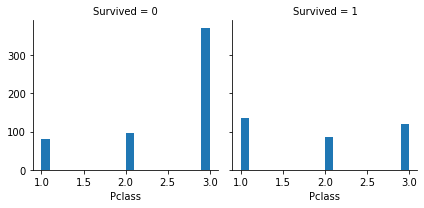

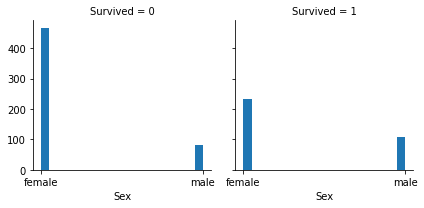

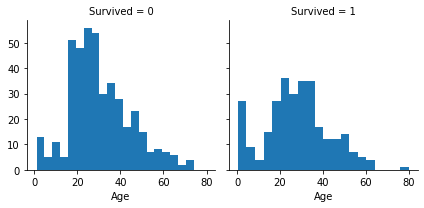

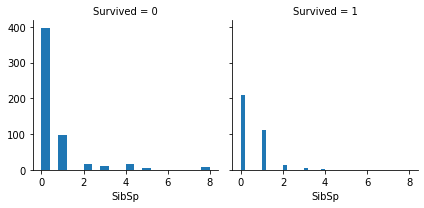

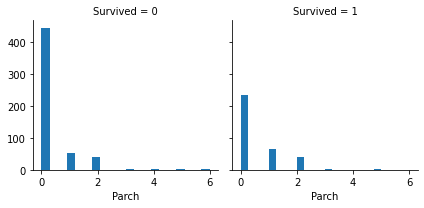

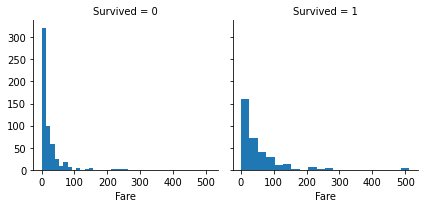

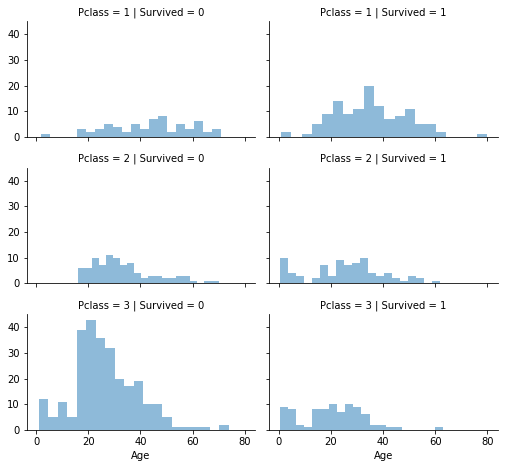

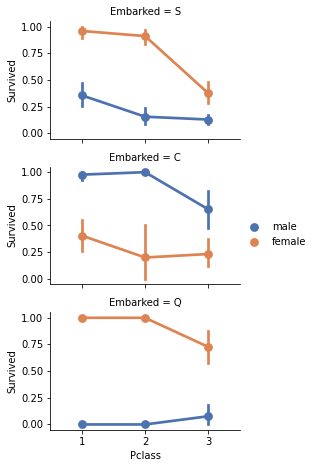

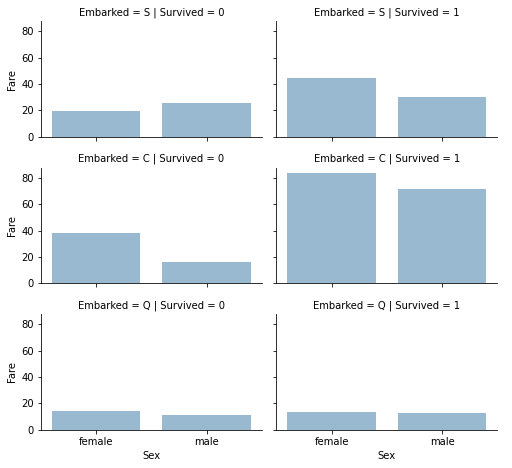

In [137]:
# визуализация зависимости значений выходного параметра от значений входных параметров 
for field in ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']:
    g = sns.FacetGrid(df, col='Survived')
    g.map(plt.hist, field, bins=20)
# обратная зависимость
# for field in ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']:
#     g = sns.FacetGrid(df, col=field)
#     g.map(plt.hist, 'Survived', bins=20)
    
# влияние 2 параметров на выходной параметр
grid = sns.FacetGrid(df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

grid = sns.FacetGrid(df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

# проверка что параметры можно объединить
grid = sns.FacetGrid(df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

In [175]:
# подготовка данных на оснований анализа

# удаляем явно лишнее
prepare = df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)

# проверяем зависимость префиксов имен от пола
prepare['Title'] = prepare.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# pd.crosstab(prepare['Title'], prepare['Sex'])

# создаем новый параметр, заменяющий имя
prepare['Title'] = prepare['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
prepare['Title'] = prepare['Title'].replace('Mlle', 'Miss')
prepare['Title'] = prepare['Title'].replace('Ms', 'Miss')
prepare['Title'] = prepare['Title'].replace('Mme', 'Mrs')
prepare[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
prepare['Title'] = prepare['Title'].map(title_mapping)
prepare['Title'] = prepare['Title'].fillna(0)
prepare = prepare.drop(['Name'], axis=1)

# нормализуем пол
prepare['Sex'] = prepare['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# нормализуем возраст
guess_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = prepare[(prepare['Sex'] == i) & (prepare['Pclass'] == j+1)]['Age'].dropna()
        age_guess = guess_df.median()
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5     
for i in range(0, 2):
    for j in range(0, 3):
        prepare.loc[ (prepare.Age.isnull()) & (prepare.Sex == i) & (prepare.Pclass == j+1), 'Age'] = guess_ages[i,j]
prepare['Age'] = prepare['Age'].astype(int)

prepare['AgeBand'] = pd.cut(prepare['Age'], 5) # 5 дипозонов
prepare[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)
prepare.loc[ prepare['Age'] <= 16, 'Age'] = 0
prepare.loc[(prepare['Age'] > 16) & (prepare['Age'] <= 32), 'Age'] = 1
prepare.loc[(prepare['Age'] > 32) & (prepare['Age'] <= 48), 'Age'] = 2
prepare.loc[(prepare['Age'] > 48) & (prepare['Age'] <= 64), 'Age'] = 3
prepare.loc[ prepare['Age'] > 64, 'Age']
prepare = prepare.drop(['AgeBand'], axis=1)

# новая фича IsAlone, заменяющая Parch / SibSp и промежуточную FamilySize
prepare['FamilySize'] = prepare['SibSp'] + prepare['Parch'] + 1
prepare[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)
prepare['IsAlone'] = 0
prepare.loc[prepare['FamilySize'] == 1, 'IsAlone'] = 1
prepare = prepare.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

# допустим..
prepare['Age*Class'] = prepare.Age * prepare.Pclass

# нормализуем Embarked
freq_port = prepare.Embarked.dropna().mode()[0]
prepare['Embarked'] = prepare['Embarked'].fillna(freq_port)
prepare['Embarked'] = prepare['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# нормализуем Fare
prepare['Fare'].fillna(prepare['Fare'].dropna().median(), inplace=True)
prepare['FareBand'] = pd.qcut(prepare['Fare'], 4)
prepare[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

prepare.loc[ prepare['Fare'] <= 7.91, 'Fare'] = 0
prepare.loc[(prepare['Fare'] > 7.91) & (prepare['Fare'] <= 14.454), 'Fare'] = 1
prepare.loc[(prepare['Fare'] > 14.454) & (prepare['Fare'] <= 31), 'Fare']   = 2
prepare.loc[ prepare['Fare'] > 31, 'Fare'] = 3
prepare['Fare'] = prepare['Fare'].astype(int)
prepare = prepare.drop(['FareBand'], axis=1)

prepare

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,1,0,5,1,2
887,1,1,1,1,2,0,2,1,1
888,0,3,1,1,2,0,2,0,3
889,1,1,0,1,2,1,1,1,1


In [176]:
# обучаем
train = prepare.drop("Survived", axis=1)
train

# далее см.
# https://www.kaggle.com/startupsci/titanic-data-science-solutions

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,3,0,1,0,0,1,0,3
1,1,1,2,3,1,3,0,2
2,3,1,1,1,0,2,1,3
3,1,1,2,3,0,3,0,2
4,3,0,2,1,0,1,1,6
...,...,...,...,...,...,...,...,...
886,2,0,1,1,0,5,1,2
887,1,1,1,2,0,2,1,1
888,3,1,1,2,0,2,0,3
889,1,0,1,2,1,1,1,1
